In [52]:
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from Bio import pairwise2
from Bio.Align import substitution_matrices
from tqdm import trange

In [224]:
extended_iupac_protein_alphabet = set('ACDEFGHIKLMNPQRSTVWYBXZJUO')

In [225]:
def clean_data(data: pd.DataFrame, tcr_col: str, pep_col: str) -> pd.DataFrame:
    print(f'Raw data size = {len(data):,}')

    data = data[data[tcr_col].notna() & data[pep_col].notna()]
    data = data.drop_duplicates([tcr_col, pep_col])
    data = data[[all(aa in extended_iupac_protein_alphabet for aa in peptide) for peptide in data[pep_col]]]

    print(f'Clean data size = {len(data):,}')

    return data

In [226]:
ALL_METADATA = {
    'vdjdb': {
        'path': '../../data/vdjdb.tsv',
        'sep': '\t',
        'tcr_col': 'CDR3',
        'pep_col': 'Epitope'
    },
    'mcpas': {
        'path': '../../data/McPAS-TCR.csv',
        'sep': ',',
        'tcr_col': 'CDR3.beta.aa',
        'pep_col': 'Epitope.peptide'
    },
    'iedb_positive': {
        'path': '../../data/iedb_positive.csv',
        'sep': ',',
        'tcr_col': 'Chain 2 CDR3 Calculated',
        'pep_col': 'Description'
    }
}

In [227]:
# metadata = ALL_METADATA['vdjdb']
# metadata = ALL_METADATA['mcpas']
metadata = ALL_METADATA['iedb_positive']

In [228]:
data = pd.read_csv(metadata['path'], sep=metadata['sep'])
data = clean_data(data, tcr_col=metadata['tcr_col'], pep_col=metadata['pep_col'])
data.head()

/Users/kyleswanson/anaconda3/envs/tcrbert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3098: DtypeWarning: Columns (8,10,11,13,15,16,17,18,19,20,21,22,23,24,25,30,31,36,37,42,44,45,46,47,48,49,50,51,52,53,54,59,60,65,66) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Raw data size = 203,890
Clean data size = 122,155


,Group Receptor ID,Receptor ID,Reference ID,Epitope ID,Description,Antigen,Organism,Response Type,Assay IDs,MHC Allele Names,...,Chain 2 CDR1 Start Curated,Chain 2 CDR1 End Curated,Chain 2 CDR1 Start Calculated,Chain 2 CDR1 End Calculated,Chain 2 CDR2 Curated,Chain 2 CDR2 Calculated,Chain 2 CDR2 Start Curated,Chain 2 CDR2 End Curated,Chain 2 CDR2 Start Calculated,Chain 2 CDR2 End Calculated
0,47,57,1004539,69921,VMAPRTLIL,"HLA class I histocompatibility antigen, Cw-3 a...",Homo sapiens (human),T cell,"1548960, 1583178","HLA-E*01:01, HLA-E*01:03",...,NaN,NaN,25.0,29.0,NaN,FVKESK,NaN,NaN,47.0,52.0
2,8493,58,1004580,16878,FLRGRAYGL,nuclear antigen EBNA-3,Human herpesvirus 4 (Epstein Barr virus),T cell,"1814845, 1814846, 1814847",HLA-B8,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
3,8493,58,1004580,144889,FLRGRFYGL,NaN,NaN,T cell,1831737,HLA-B8,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
4,8493,58,1017865,142137,EEYLQAFTY,ATP-binding cassette sub-family D member 3,Homo sapiens (human),T cell,1778798,HLA-B*44:05,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0
6,8493,58,1017865,156273,EEYLKAWTF,NaN,NaN,T cell,1779482,HLA-B*44:05,...,NaN,NaN,25.0,29.0,NaN,FQNEAQ,NaN,NaN,47.0,52.0


In [230]:
peptides = sorted(data[metadata['pep_col']].unique())
print(f'Num unique peptides = {len(peptides):,}')

Num unique peptides = 959


In [231]:
tcrs = sorted(data[metadata['tcr_col']].unique())
print(f'Num unique TCRs = {len(tcrs):,}')

Num unique TCRs = 116,274


In [232]:
peptide_to_tcr = defaultdict(set)
tcr_to_peptide = defaultdict(set)

for peptide, tcr in zip(data[metadata['pep_col']], data[metadata['tcr_col']]):
    peptide_to_tcr[peptide].add(tcr)
    tcr_to_peptide[tcr].add(peptide)

In [233]:
tcr_counts_per_peptide = Counter([len(tcrs) for tcrs in peptide_to_tcr.values()])
tcr_counts_per_peptide.most_common()

[(1, 499),
 (2, 53),
 (3, 35),
 (5, 30),
 (4, 21),
 (6, 16),
 (8, 13),
 (10, 10),
 (9, 8),
 (7, 7),
 (19, 6),
 (23, 6),
 (14, 5),
 (24, 5),
 (13, 5),
 (44, 4),
 (11, 4),
 (28, 4),
 (17, 4),
 (15, 4),
 (40, 4),
 (12, 4),
 (54, 3),
 (18, 3),
 (25, 3),
 (32, 3),
 (16, 3),
 (21, 3),
 (27, 3),
 (39, 3),
 (42, 3),
 (130, 3),
 (35, 3),
 (22, 3),
 (31, 2),
 (46, 2),
 (88, 2),
 (90, 2),
 (164, 2),
 (248, 2),
 (64, 2),
 (107, 2),
 (29, 2),
 (139, 2),
 (75, 2),
 (63, 2),
 (244, 2),
 (38, 2),
 (30, 2),
 (169, 2),
 (53, 2),
 (199, 2),
 (57, 2),
 (87, 2),
 (45, 2),
 (103, 2),
 (74, 2),
 (26, 2),
 (41, 2),
 (93, 1),
 (36, 1),
 (321, 1),
 (5802, 1),
 (662, 1),
 (931, 1),
 (1774, 1),
 (301, 1),
 (1377, 1),
 (2710, 1),
 (193, 1),
 (1751, 1),
 (11573, 1),
 (176, 1),
 (2931, 1),
 (1281, 1),
 (353, 1),
 (609, 1),
 (1712, 1),
 (537, 1),
 (437, 1),
 (980, 1),
 (613, 1),
 (807, 1),
 (2568, 1),
 (3848, 1),
 (1319, 1),
 (5793, 1),
 (216, 1),
 (222, 1),
 (841, 1),
 (451, 1),
 (3424, 1),
 (1297, 1),
 (638, 1),
 (

In [234]:
peptide_counts_per_tcr = Counter([len(peptides) for peptides in tcr_to_peptide.values()])
peptide_counts_per_tcr.most_common()

[(1, 112388),
 (2, 2956),
 (3, 576),
 (4, 164),
 (5, 73),
 (6, 43),
 (7, 24),
 (8, 12),
 (9, 6),
 (10, 5),
 (11, 5),
 (13, 4),
 (14, 3),
 (12, 3),
 (15, 2),
 (25, 2),
 (48, 1),
 (34, 1),
 (33, 1),
 (17, 1),
 (21, 1),
 (22, 1),
 (24, 1),
 (16, 1)]

In [235]:
scoring = substitution_matrices.load("BLOSUM62")
gap_open = -5.0
gap_extend = -0.5
num_peptides = 100  # len(peptides)
scores = np.zeros((num_peptides, num_peptides))

for i in trange(num_peptides):
    for j in range(i + 1, num_peptides):
        scores[i, j] = pairwise2.align.globalds(peptides[i], peptides[j], scoring, gap_open, gap_extend, score_only=True)

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


In [236]:
scores_flat = [scores[i, j] for i in range(num_peptides) for j in range(i + 1, num_peptides)]

(array([  1.,   1.,   3.,   1.,   7.,  10.,  14.,  15.,  30.,  53.,  59.,
         98., 116., 148., 198., 271., 296., 329., 349., 303., 465., 302.,
        314., 280., 235., 191., 167., 115., 106.,  85.,  70.,  52.,  34.,
         29.,  24.,  17.,  19.,   6.,   8.,   8.,  15.,   2.,   2.,   0.,
          2.,   4.,   0.,   0.,   0.,   2.,   2.,   8.,   5.,  10.,   5.,
          3.,   8.,   7.,   4.,   6.,   1.,   6.,   6.,   1.,   1.,   2.,
          2.,   1.,   2.,   0.,   1.,   1.,   3.,   1.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-22.   , -20.975, -19.95 , -18.925, -17.9  , -16.875, -15.85 ,
        -14.825, -13.8  , -12.775, -11.75 , -10.725,  -9.7  ,  -8.675,
         -7.65 ,  -6.625,  -5.6  ,  -4.575,  -3.55 ,  -2.525,  -1.5  ,
         -0.475,   0.55 ,   1.575,   2.6  ,   3.625,   4.65 ,   5.675,
          6.7  ,   7.725,   8.75 ,

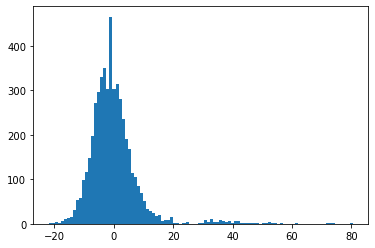

In [237]:
plt.hist(scores_flat, bins=100)

In [238]:
mean = np.mean(scores_flat)
std = np.std(scores_flat)
print(f'Scores = {mean:.2f} +/- {std:.2f}')

threshold = mean + 3 * std
print(f'Threshold = mean + 3 * std = {threshold}')

I, J = np.where(scores > threshold)

Scores = -0.18 +/- 8.39
Threshold = mean + 3 * std = 24.98550051381914


In [239]:
for i, j in zip(I, J):
    print(peptides[i], peptides[j])

AAGIGILTV ALAGIGILTV
AAGIGILTV ALGIGILTV
AAQNVHFWKALNQL AAQRIHFFKNLSLL
AAQRIHFFKNLSLL AENPVVHFFKNIATPR
AAQRIHFFKNLSLL ANPVVHFFKNIVTPR
AAQRIHFFKNLSLL ARSVFHFFRGTALL
ACDPHSGHFV ALDPHSGHFV
ADGLAYFRSSFKGG ADPADPLAFFSSAIKGGGGSLV
ADGLAYFRSSFKGG ANGVAFFLTPFKKA
ADLIAYFKAATKF ADLIAYLKQASK
ADLIAYFKAATKF ADLIAYLKQATAK
ADLIAYFKAATKF ADLIAYLKQATK
ADLIAYFKAATKF ADLIAYLKQATKK
ADLIAYFKAATKF ADLIAYPKAATKF
ADLIAYFKAATKF ANERADLIAYLEQATK
ADLIAYFKAATKF ANERADLIAYLKQATK
ADLIAYFKAATKF ANERADLIAYLRQATK
ADLIAYLKQASK ADLIAYLKQATAK
ADLIAYLKQASK ADLIAYLKQATK
ADLIAYLKQASK ADLIAYLKQATKK
ADLIAYLKQASK ADLIAYPKAATKF
ADLIAYLKQASK ANERADLIAYLEQATK
ADLIAYLKQASK ANERADLIAYLKQATK
ADLIAYLKQASK ANERADLIAYLRQATK
ADLIAYLKQATAK ADLIAYLKQATK
ADLIAYLKQATAK ADLIAYLKQATKK
ADLIAYLKQATAK ADLIAYPKAATKF
ADLIAYLKQATAK ANERADLIAYLEQATK
ADLIAYLKQATAK ANERADLIAYLKQATK
ADLIAYLKQATAK ANERADLIAYLRQATK
ADLIAYLKQATK ADLIAYLKQATKK
ADLIAYLKQATK ADLIAYPKAATKF
ADLIAYLKQATK ANERADLIAYLEQATK
ADLIAYLKQATK ANERADLIAYLKQATK
ADLIAYLKQATK ANERADLIAYLRQAT

In [240]:
graph = nx.Graph()
graph.add_nodes_from(peptides[:num_peptides])
for i, j in zip(I, J):
    graph.add_edge(peptides[i], peptides[j])

In [241]:
components = [sorted(component) for component in sorted(nx.connected_components(graph), key=len, reverse=True) if len(component) > 1]
connected_peptides = [peptide for component in components for peptide in component]
connnected_graph = graph.subgraph(connected_peptides)

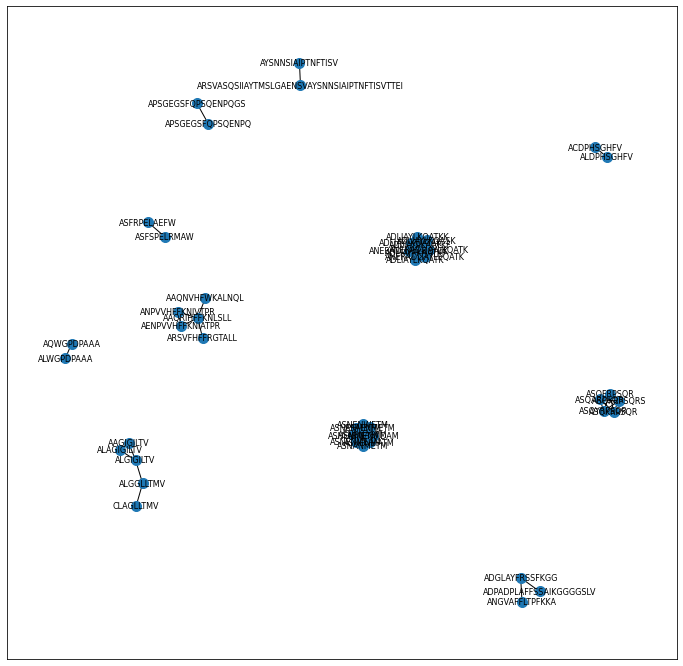

In [242]:
plt.figure(figsize=(12,12)) 
nx.draw_networkx(connnected_graph, node_size=100, font_size=8)

In [243]:
for index, component in enumerate(components):
    tcr_to_count = defaultdict(int)

    for peptide in component:
        for tcr in peptide_to_tcr[peptide]:
            tcr_to_count[tcr] += 1

    num_shared_tcrs = sum(count > 1 for count in tcr_to_count.values())

    if num_shared_tcrs > 0:
        print(f'Component {index}\n')
        print(f'Num peptides = {len(component):,}')
        print(f'Num shared TCRs = {num_shared_tcrs:,}\n')

        for tcr, count in tcr_to_count.items():
            if count > 1:
                print(f'{tcr}: {count:,}')

        print('\n' + '-' * 20 + '\n')

Component 0

Num peptides = 9
Num shared TCRs = 2

ASSLNWSQDTQY: 7
ASSLNNANSDYT: 4

--------------------

Component 1

Num peptides = 9
Num shared TCRs = 2

ASSRDLGRDTQY: 7
ASSSRTGGHAEQF: 3

--------------------

Component 2

Num peptides = 5
Num shared TCRs = 2

ASSHAGLGVEQY: 2
ASSYVSQNNEQF: 2

--------------------

Component 3

Num peptides = 5
Num shared TCRs = 2

SARDLTSGANNEQF: 3
ATSALGDTQY: 2

--------------------

Component 4

Num peptides = 5
Num shared TCRs = 2

ASGDAGGGYEQY: 4
ASGDASGAETLY: 2

--------------------

Component 5

Num peptides = 3
Num shared TCRs = 1

ASSLNNANSDYT: 2

--------------------

Component 6

Num peptides = 2
Num shared TCRs = 1

ASSVVAGFNEQF: 2

--------------------

Component 7

Num peptides = 2
Num shared TCRs = 1

ASSLWEKLAKNIQY: 2

--------------------

Component 10

Num peptides = 2
Num shared TCRs = 1

ASTGSYGYT: 2

--------------------

